In [1]:
import random
from collections import defaultdict, OrderedDict
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams

In [2]:
rcParams['figure.figsize'] = (20, 10)

In [3]:
def run_iter(f, n=1000000):
    result = defaultdict(int)
    for i in range(n):
        result[f()] += 1
    return OrderedDict(sorted(result.items()))

def dice_throw():
    return random.randint(1, 6) + random.randint(1, 6)


def dice_throw_combo():
    dice_one, dice_two = random.randint(1, 6), random.randint(1, 6)
    return dice_one + dice_two, dice_one == dice_two


def dice_throw_wrong():
    return random.randint(1, 12)


def plot_res(result, title):
    x, y = result.keys(), result.values()
    plt.title(title)
    plt.bar(x, y)

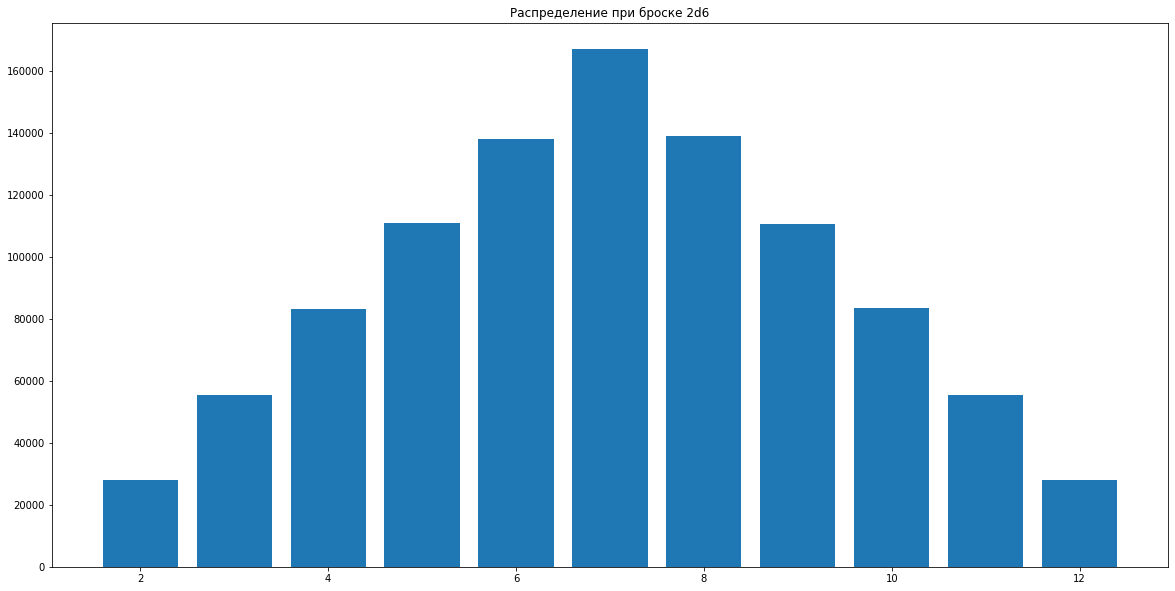

In [4]:
plot_res(run_iter(dice_throw), 'Распределение при броске 2d6')

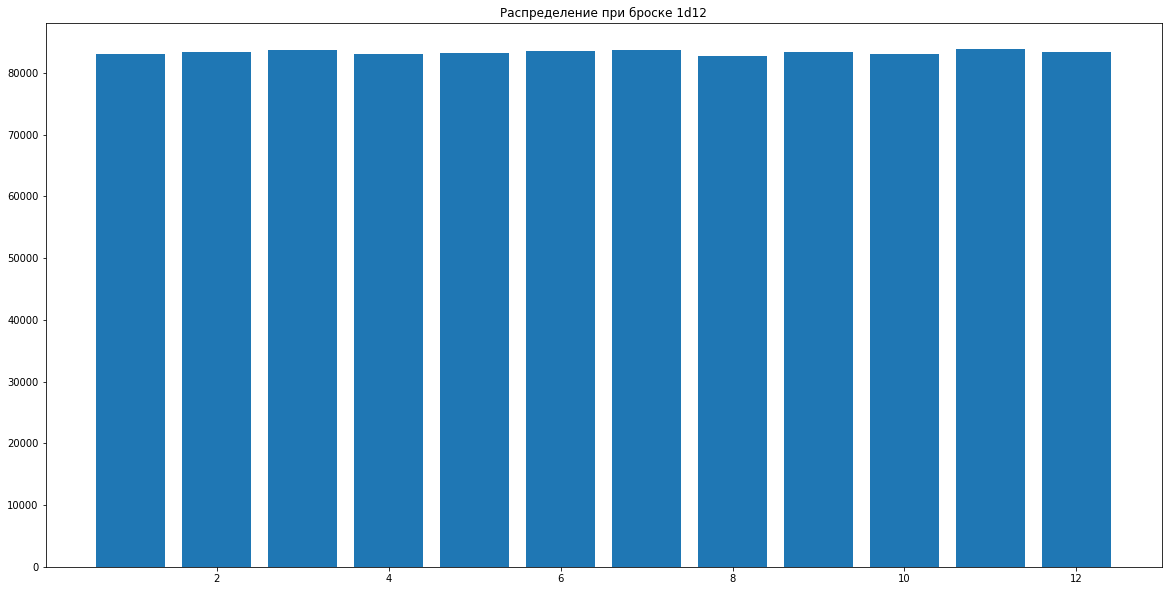

In [5]:
plot_res(run_iter(dice_throw_wrong), 'Распределение при броске 1d12')

In [6]:
chance_array = [
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    'back',
    6,
    15,
    10,
    24,
    0,
    39
]
treasury_array = [
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    10,
    1
]

In [7]:
def run_game_simulation(f, with_prison=False, with_combo=False, with_cards=False, n=5000000):
    field = np.zeros(40)
    field[0] = 1 
    redirect = np.zeros(40)
    combo = [False, False, False]
    current = 0
    for i in range(n):
        throw = f()
        if with_combo:
            throw, isEqual = throw
            if isEqual:
                combo = combo[1:3] + [True]
            else:
                combo = combo[1:3] + [False]
            if all(combo):
                combo = [False, False, False]
                current = 10
                redirect[current] += 1
                continue
        current = (current + throw) % 40 
        if with_prison and current == 30: 
            if with_combo:
                combo = [False, False, False]
            current = 10
            redirect[current] += 1
            continue
        if with_cards:
            if current == 2 or current == 17 or current == 33:
                r_tmp = random.choice(treasury_array)
                if r_tmp is not None:
                    current = r_tmp
                    if with_combo and current == 10:
                        combo = [False, False, False]
                    redirect[current] += 1
                    continue
            if current == 7 or current == 22 or current == 36:
                r_tmp = random.choice(chance_array)
                if r_tmp is not None:
                    if r_tmp == 'back':
                        current = current - 3
                        if current == 33:
                            r_tmp = random.choice(treasury_array)
                            if r_tmp is not None:
                                current = r_tmp
                                if with_combo and current == 10:
                                    combo = [False, False, False]
                                redirect[current] += 1
                                continue
                        redirect[current] += 1
                        continue
                    current = r_tmp
                    if with_combo and current == 10:
                        combo = [False, False, False]
                    redirect[current] += 1
                    continue
        field[current] += 1
    return field / n, redirect / n


def plot_result(result, title, sor=False, min_r=0, max_r=1):
    plt.title(title)
    plt.ylim([min_r, max_r])
    y = np.arange(40)
    x, r = result
    s = x + r
    if sor:
        data = list(zip(y, x, r, x + r))
        data.sort(reverse=True, key=lambda row: row[3])
        y, x, r, s = list(zip(*data)) 
    y = [str(i) for i in y]
    plt.bar(y, x)
    plt.bar(y, r, bottom=x, tick_label=y)
    for i in range(len(s)):
        plt.annotate(str(s[i])[:5], xy=(y[i], s[i] + 0.001), rotation=90, ha='center')

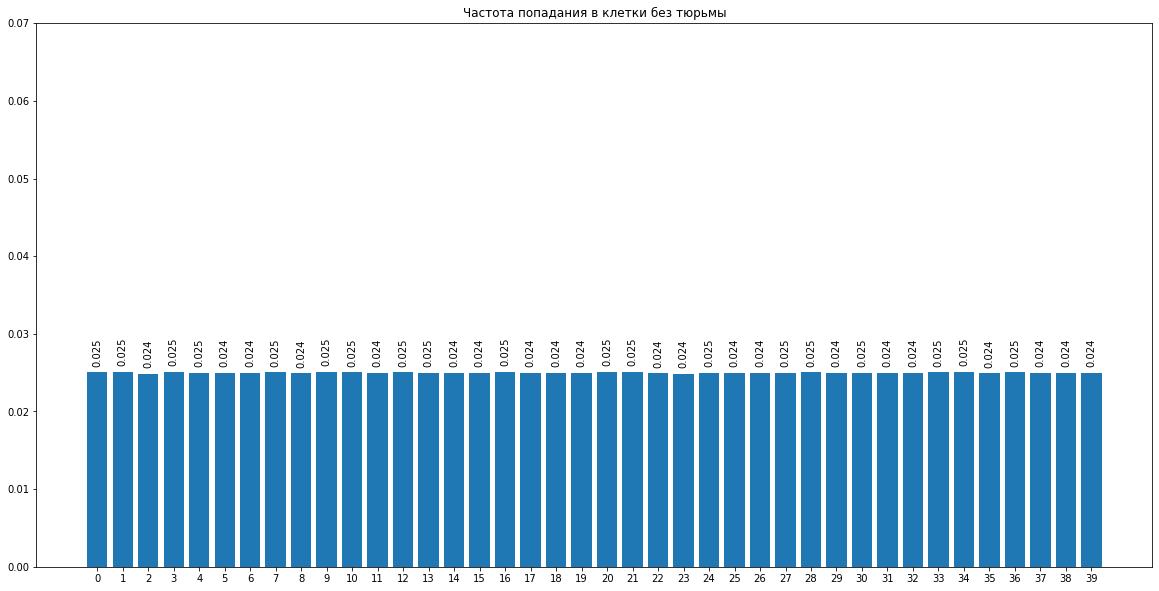

In [8]:
plot_result(run_game_simulation(dice_throw), 'Частота попадания в клетки без тюрьмы', min_r=0, max_r=0.07)

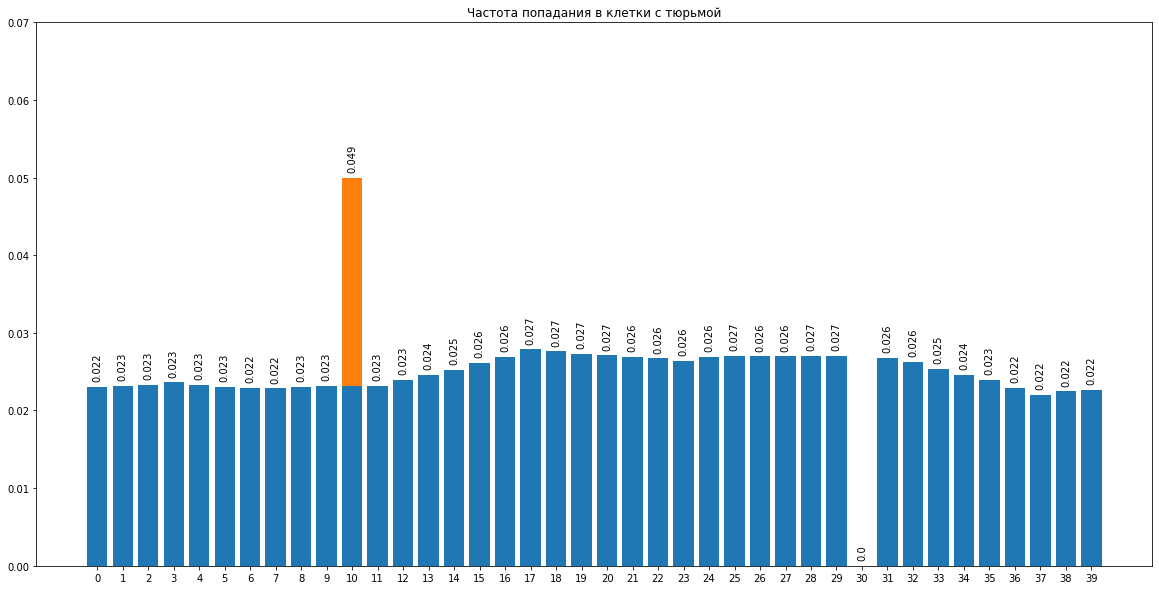

In [9]:
plot_result(run_game_simulation(dice_throw, with_prison=True), 'Частота попадания в клетки с тюрьмой', min_r=0, max_r=0.07)

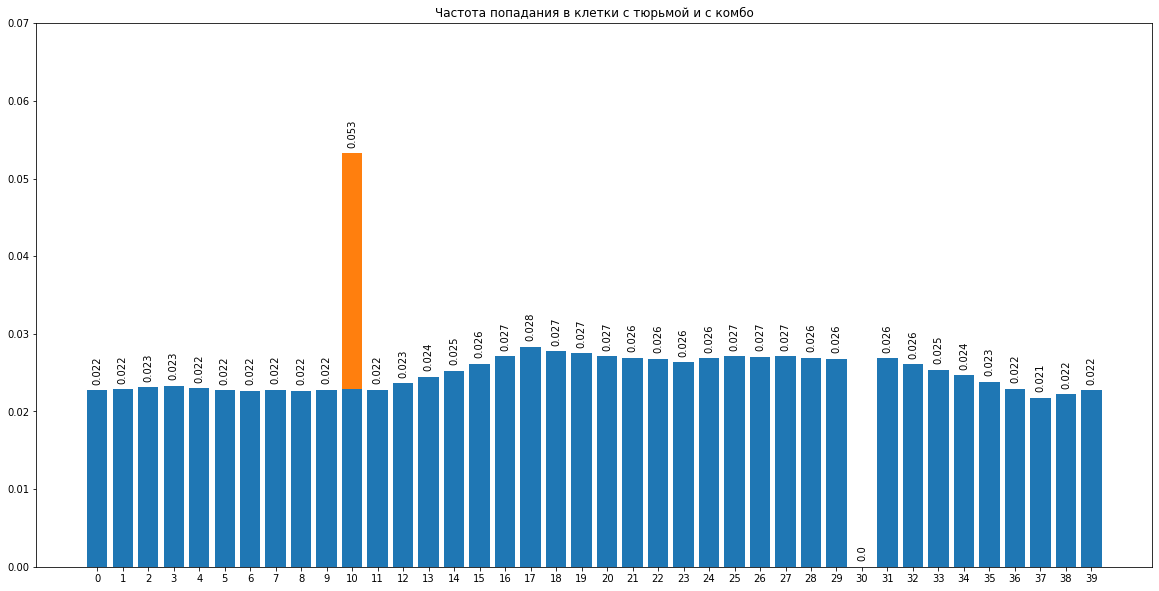

In [10]:
plot_result(run_game_simulation(dice_throw_combo, with_prison=True, with_combo=True), 'Частота попадания в клетки с тюрьмой и с комбо', min_r=0, max_r=0.07)

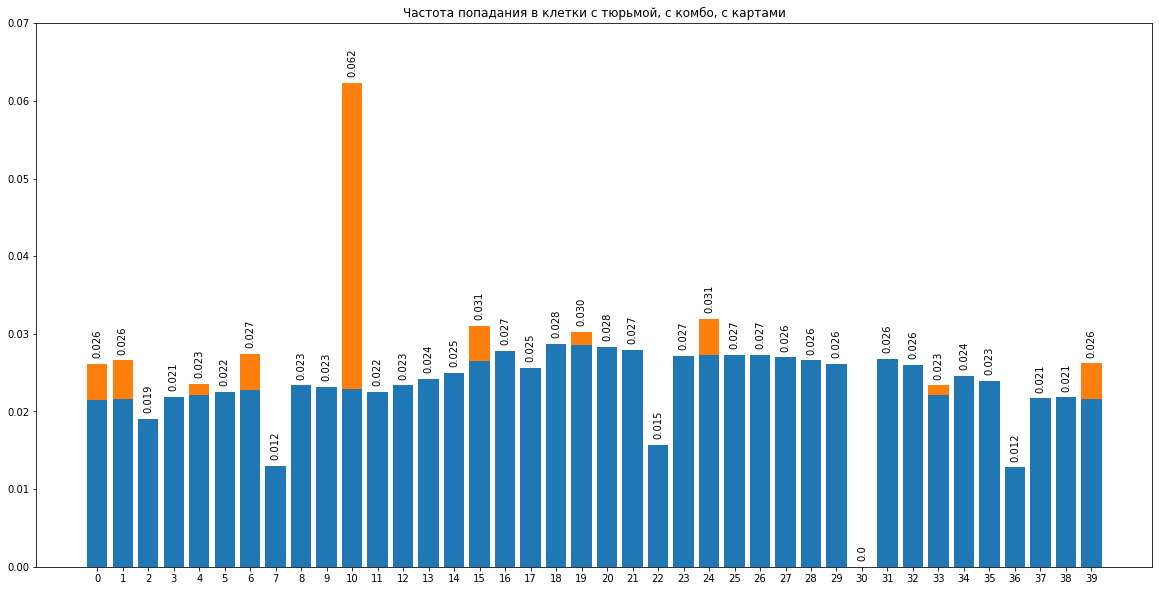

In [11]:
plot_result(run_game_simulation(dice_throw_combo, with_cards=True, with_prison=True, with_combo=True), 'Частота попадания в клетки с тюрьмой, с комбо, c картами', min_r=0, max_r=0.07)

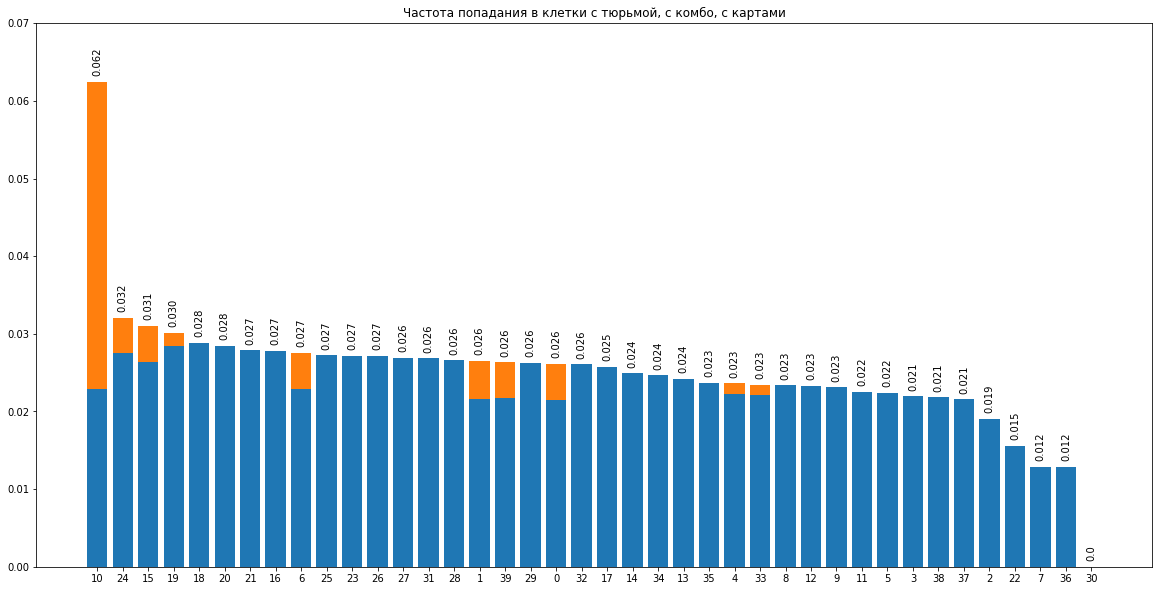

In [12]:
plot_result(run_game_simulation(dice_throw_combo, with_cards=True, with_prison=True, with_combo=True), 'Частота попадания в клетки с тюрьмой, с комбо, c картами', sor=True, min_r=0, max_r=0.07)

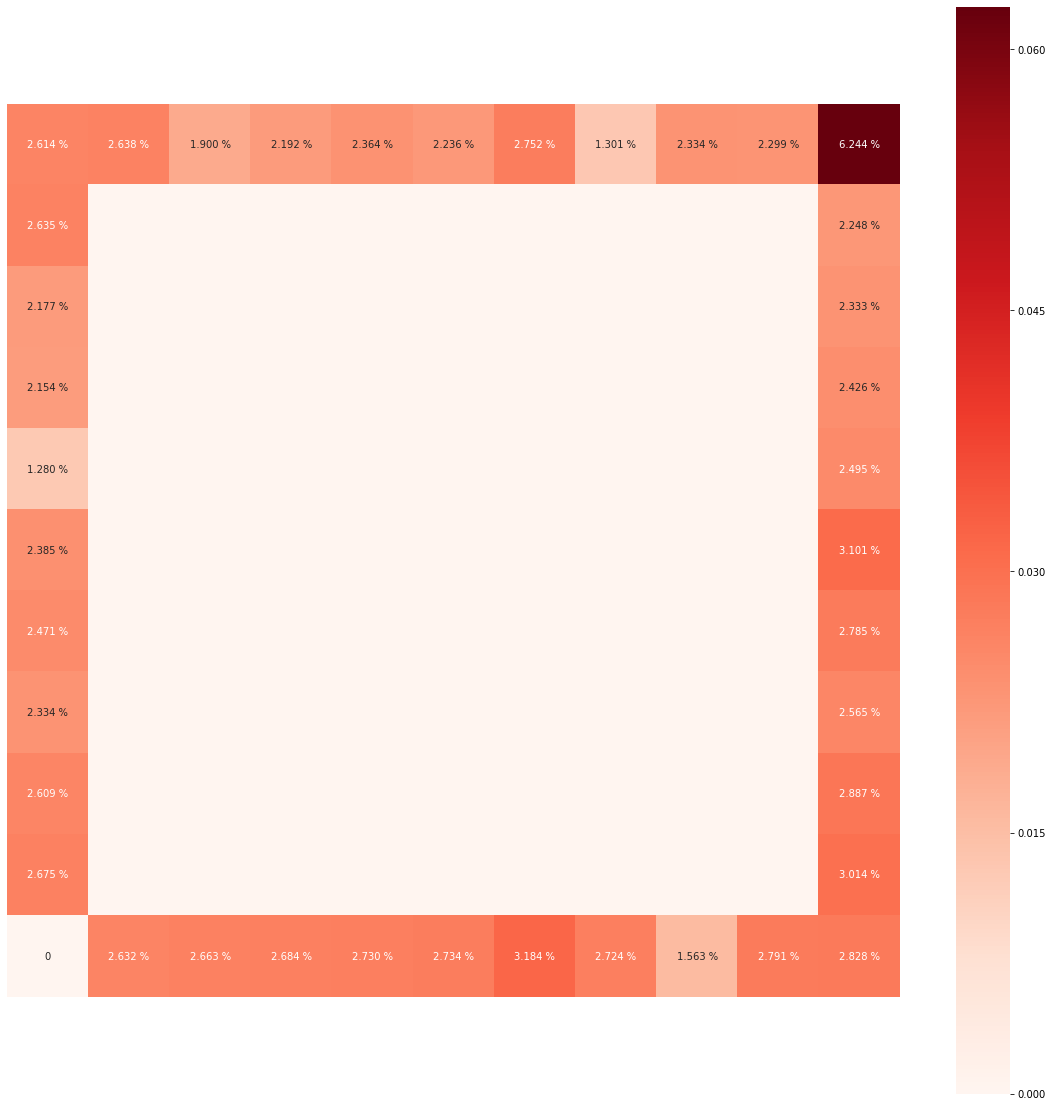

In [14]:
field = np.zeros((11, 11))
organic, redirect = run_game_simulation(dice_throw_combo, with_cards=True, with_prison=True, with_combo=True)
result = organic + redirect
field[0, :10] = result[:10]
field[:10, 10] = result[10:20]
field[10, 1:] = result[20:30][::-1]
field[1:, 0] = result[30:40][::-1]
labels = np.array([[str(cell * 100)[:5] + ' %' if cell != 0 else '' for cell in row] for row in field])
labels[10, 0] = '0'
plt.figure(figsize=(20, 20))
sns.heatmap(field, square=True, xticklabels=False, yticklabels=False, annot=labels, fmt = '', cmap='Reds')